# Test biaslyze with the movie review dataset

Data source: https://www.kaggle.com/datasets/deepcontractor/supreme-court-judgment-prediction?resource=download

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/stinal/Documents/BIASLYZE/repositories/biaslyze/')

In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

## Load and prepare data

In [4]:
df = pd.read_csv("../data/court-judgment/justice.csv"); df.head()

,Unnamed: 0,ID,name,href,docket,term,first_party,second_party,facts,facts_len,majority_vote,minority_vote,first_party_winner,decision_type,disposition,issue_area
0,0,50606,Roe v. Wade,https://api.oyez.org/cases/1971/70-18,70-18,1971,Jane Roe,Henry Wade,"<p>In 1970, Jane Roe (a fictional name used in...",501,7,2,True,majority opinion,reversed,NaN
1,1,50613,Stanley v. Illinois,https://api.oyez.org/cases/1971/70-5014,70-5014,1971,"Peter Stanley, Sr.",Illinois,<p>Joan Stanley had three children with Peter ...,757,5,2,True,majority opinion,reversed/remanded,Civil Rights
2,2,50623,Giglio v. United States,https://api.oyez.org/cases/1971/70-29,70-29,1971,John Giglio,United States,<p>John Giglio was convicted of passing forged...,495,7,0,True,majority opinion,reversed/remanded,Due Process
3,3,50632,Reed v. Reed,https://api.oyez.org/cases/1971/70-4,70-4,1971,Sally Reed,Cecil Reed,"<p>The Idaho Probate Code specified that ""male...",378,7,0,True,majority opinion,reversed/remanded,Civil Rights
4,4,50643,Miller v. California,https://api.oyez.org/cases/1971/70-73,70-73,1971,Marvin Miller,California,"<p>Miller, after conducting a mass mailing cam...",305,5,4,True,majority opinion,vacated/remanded,First Amendment


In [5]:
missing_values_count = df.isnull().sum()
missing_values_count[0:100]

Unnamed: 0              0
ID                      0
name                    0
href                    0
docket                  0
term                    0
first_party             1
second_party            1
facts                   0
facts_len               0
majority_vote           0
minority_vote           0
first_party_winner     15
decision_type           7
disposition            72
issue_area            142
dtype: int64

In [6]:
# drop missing values 
df = df.dropna()

In [7]:
missing_values_count = df.isnull().sum()
missing_values_count[0:100]

Unnamed: 0            0
ID                    0
name                  0
href                  0
docket                0
term                  0
first_party           0
second_party          0
facts                 0
facts_len             0
majority_vote         0
minority_vote         0
first_party_winner    0
decision_type         0
disposition           0
issue_area            0
dtype: int64

In [8]:
# how many total missing values do we have?
total_cells = np.product(df.shape)
total_missing = missing_values_count.sum()

# percent of data that is missing
percent_missing = (total_missing/total_cells) * 100
print(percent_missing)

0.0


In [9]:
df.first_party_winner.astype(int)

1       1
2       1
3       1
4       1
5       1
       ..
3297    1
3298    1
3299    0
3300    1
3302    1
Name: first_party_winner, Length: 3098, dtype: int64

## Train Model

In [53]:
clf = make_pipeline(TfidfVectorizer(min_df=10, max_features=30000, stop_words="english"), LogisticRegression())

In [54]:
clf.fit(df.facts, df.first_party_winner.astype(int))

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=30000, min_df=10,
                                 stop_words='english')),
                ('logisticregression', LogisticRegression())])

In [55]:
train_pred = clf.predict(df.facts)
print(accuracy_score(df.first_party_winner.astype(int), train_pred))

0.7443511943189154


## Test LIME based bias detection with keywords

In [56]:
from biaslyze.evaluators import LimeBiasEvaluator
from biaslyze.bias_detectors import LimeKeywordBiasDetector

In [57]:
bias_detector = LimeKeywordBiasDetector(
    bias_evaluator=LimeBiasEvaluator(n_lime_samples=1000),
    n_top_keywords=30,
    use_tokenizer=True
)

In [58]:
test_texts = df.facts.sample(1000)
detection_res = bias_detector.detect(texts=test_texts, predict_func=clf.predict_proba)

2023-05-05 13:21:34.648 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 1000 texts...
  0%|                                                                                   | 0/1000 [00:00<?, ?it/s]/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
100%|███████████████████████████████████████████████████████████████████████| 1000/1000 [00:07<00:00, 135.18it/s]
2023-05-05 13:21:42.048 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 848 texts with protected concepts.
2023-05-05 13:21:42.049 | INFO     | biaslyze.evaluators:evaluate:44 - Started bias detection on 848 samples...
  2%|█▍               

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_837503/1188492920.py", line 2, in <module>
    detection_res = bias_detector.detect(texts=test_texts, predict_func=clf.predict_proba)
  File "/home/stinal/Documents/BIASLYZE/repositories/biaslyze/biaslyze/bias_detectors/lime_keyword_biasdetector.py", line 69, in detect
    evaluation_result = self.bias_evaluator.evaluate(
  File "/home/stinal/Documents/BIASLYZE/repositories/biaslyze/biaslyze/evaluators.py", line 48, in evaluate
    self.explainer.fit(text, predict_func)
  File "/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/lib/python3.10/site-packages/eli5/lime/lime.py", line 248, in fit
    X = self.vec_.transform(samples)
  File "/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/l

In [ ]:
detection_res.summary()

In [ ]:
detection_res.details(group_by_concept=True)

In [ ]:
test_df = df.iloc[test_texts.index]

In [ ]:
test_df[test_df.target].reset_index().comment_text[4]

In [ ]:
from bokeh.io import show, output_notebook

output_notebook()

dashboard = detection_res.dashboard()
show(dashboard)

In [ ]:
pos_dashboard = detection_res.dashboard(use_position=True)
show(pos_dashboard)

## Experiment with global importance of concept-keywords

In [59]:
from biaslyze.concept_detectors import KeywordConceptDetector
from biaslyze.evaluators import LimeBiasEvaluator, MaskedBiasEvaluator
from biaslyze.counterfactual_score import plot_scores, calculate_all_scores
from tqdm import tqdm
from biaslyze.concepts import CONCEPTS
import matplotlib.pyplot as plt

In [60]:
key_detect = KeywordConceptDetector()

In [61]:
detected_texts = key_detect.detect(texts=df.facts.sample(1500))

2023-05-05 13:22:03.875 | INFO     | biaslyze.concept_detectors:detect:33 - Started keyword-based concept detection on 1500 texts...
100%|██████████████████████████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 4301.67it/s]
2023-05-05 13:22:04.226 | INFO     | biaslyze.concept_detectors:detect:49 - Done. Found 1499 texts with protected concepts.


In [62]:
len(detected_texts)

1499

In [63]:
detected_texts[0]

"<p>In 1986, after being convicted for simple assault, institutional vandalism, and criminal mischief, Edward R. Coss, Jr., filed a petition for relief, but the Pennsylvania courts never ruled on the petition. In 1990, after he had served the full sentences for his 1986 convictions, Coss was convicted of aggravated assault. Ultimately, the sentencing court did not consider Coss' 1986 convictions in determining his eligible sentencing range. In choosing a sentence within the applicable range, the court considered several factors including Coss' extensive criminal record, making reference to his 1986 convictions. Coss then filed a petition for a writ of habeas corpus, claiming that his 1986 convictions were constitutionally invalid. The Federal District Court denied the petition reasoning that Coss had not been prejudiced by his 1986 counsel's ineffectiveness. The Court of Appeals found that Coss would not have been convicted in 1986 but for the ineffective assistance. The court remanded

In [64]:
from typing import List

class Sample:
    
    def __init__(self, text: str, keyword: str, concept: str, tokenized: List[str]):
        self.text = text
        self.keyword = keyword
        self.concept = concept
        self.tokenized = tokenized
    
    def __repr__(self):
        return f"concept={self.concept}; keyword={self.keyword}; text={self.text}"

In [65]:
score_df = calculate_all_scores(texts=detected_texts, concept="gender", clf=clf, n_samples=10000)

0it [00:00, ?it/s]/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
1499it [00:15, 98.77it/s] 


Extracted 2935 sample texts for concept gender


100%|████████████████████████████████████████████████████████████████████████████| 77/77 [00:53<00:00,  1.44it/s]


In [66]:
score_df.describe()

,female,feminine,woman,women,mrs.,ms.,girl,mother,daughter,wife,...,male,mr.,man,men,boy,father,son,husband,brother,brothers
count,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,...,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000
mean,0.008864,0.000036,-0.011666,-0.001912,0.020723,-0.020670,0.013687,-0.003096,-0.001110,0.017553,...,-0.003805,-0.015289,0.005034,-0.000557,-0.019995,0.000456,0.012576,0.003637,0.005893,0.019205
std,0.009376,0.004767,0.010567,0.006799,0.015775,0.015930,0.011848,0.006819,0.007038,0.013894,...,0.007991,0.012330,0.007167,0.006590,0.015705,0.007102,0.010948,0.007176,0.008474,0.014875
min,-0.027825,-0.065169,-0.099539,-0.054819,-0.002709,-0.141878,-0.017088,-0.057795,-0.053682,-0.010988,...,-0.069885,-0.112178,-0.040343,-0.051114,-0.140139,-0.049553,-0.020742,-0.040961,-0.038425,-0.004747
25%,0.004173,0.000000,-0.014598,-0.002770,0.010225,-0.025747,0.006636,-0.003992,-0.002113,0.008485,...,-0.004997,-0.019391,0.002229,-0.001511,-0.024839,-0.000750,0.006098,0.001375,0.002508,0.009461
50%,0.006095,0.000000,-0.008671,-0.001185,0.015498,-0.015631,0.009992,-0.002031,-0.000649,0.012953,...,-0.002490,-0.011504,0.003306,-0.000339,-0.015138,0.000261,0.009268,0.002164,0.003745,0.014349
75%,0.010557,0.000000,-0.005672,-0.000425,0.026180,-0.010503,0.016767,-0.001062,0.000073,0.022329,...,-0.001267,-0.007588,0.005925,0.000385,-0.010113,0.001322,0.015633,0.004355,0.006955,0.024250
max,0.097961,0.066273,0.026277,0.060103,0.140221,0.006907,0.113964,0.055782,0.063159,0.133520,...,0.054088,0.015562,0.084376,0.064806,0.010564,0.068669,0.112376,0.079883,0.087263,0.133710


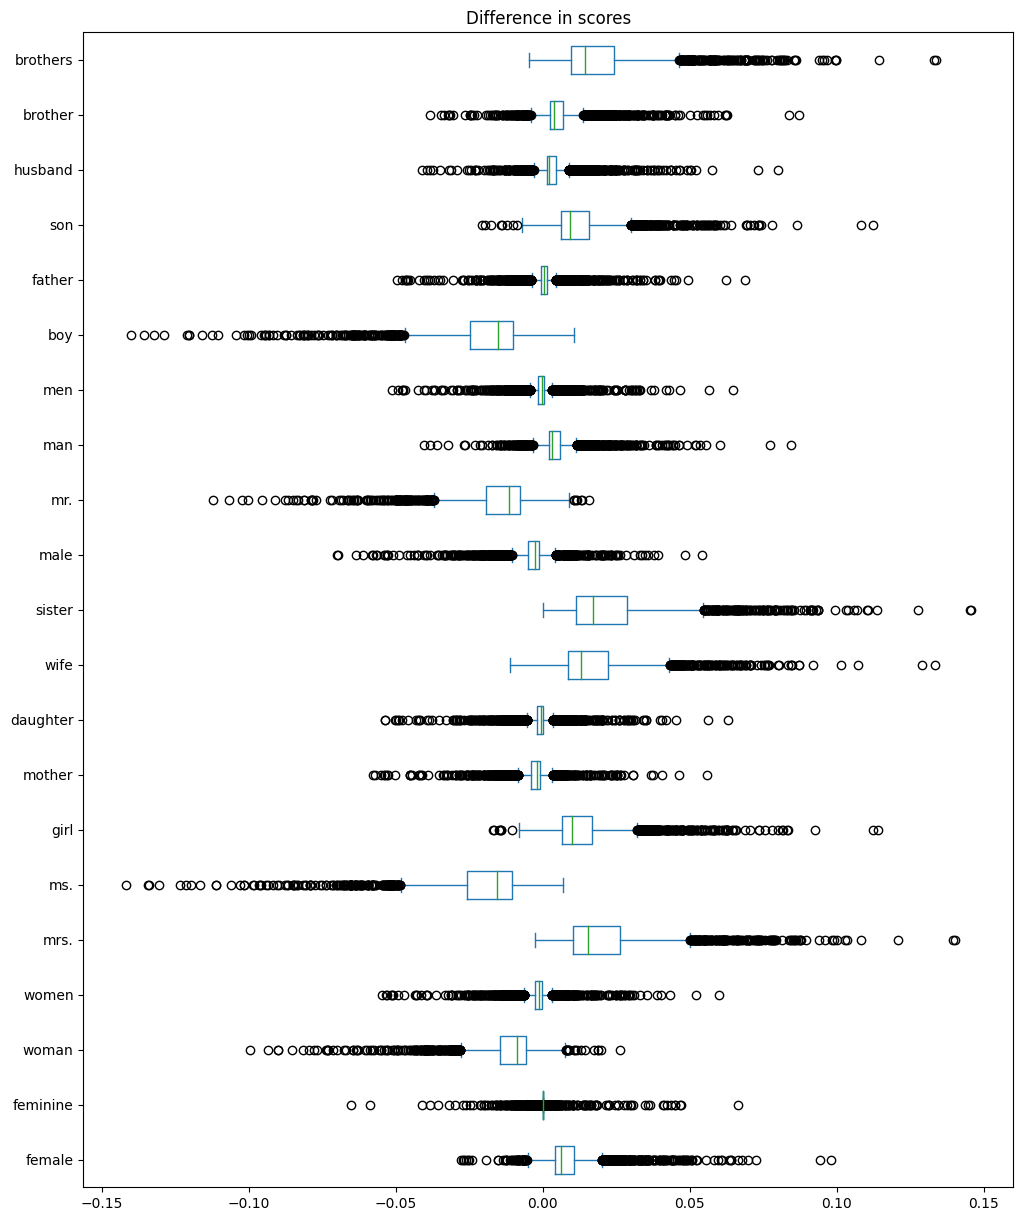

In [68]:
score_df.plot.box(vert=False, figsize=(12, 15));
plt.title("Difference in scores");
plt.savefig("court_gender_array")

SenseScore: 0.0089036 (+- 0.0093765)


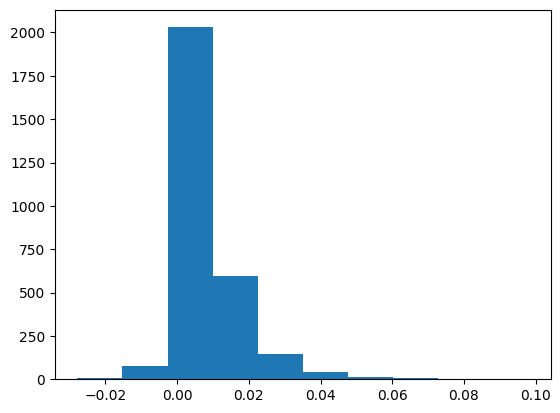

In [69]:
bias_keyword = "female"

score_diffs = score_df[bias_keyword].values
score_diffs = score_diffs[score_diffs != 0.0]
print(f"SenseScore: {np.mean(score_diffs):.5} (+- {np.std(score_diffs):.5})")

plt.hist(score_diffs);

SenseScore: -0.020016 (+- 0.015698)


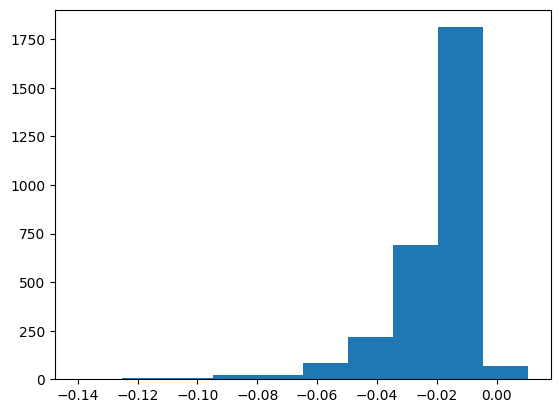

In [70]:
bias_keyword = "boy"

score_diffs = score_df[bias_keyword].values
score_diffs = score_diffs[score_diffs != 0.0]
print(f"SenseScore: {np.mean(score_diffs):.5} (+- {np.std(score_diffs):.5})")

plt.hist(score_diffs);

In [71]:
ethnicity_score_df = calculate_all_scores(texts=detected_texts, concept="ethnicity", clf=clf, n_samples=10000)

0it [00:00, ?it/s]/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
1499it [00:11, 131.64it/s]


Extracted 155 sample texts for concept ethnicity


100%|████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 26.90it/s]


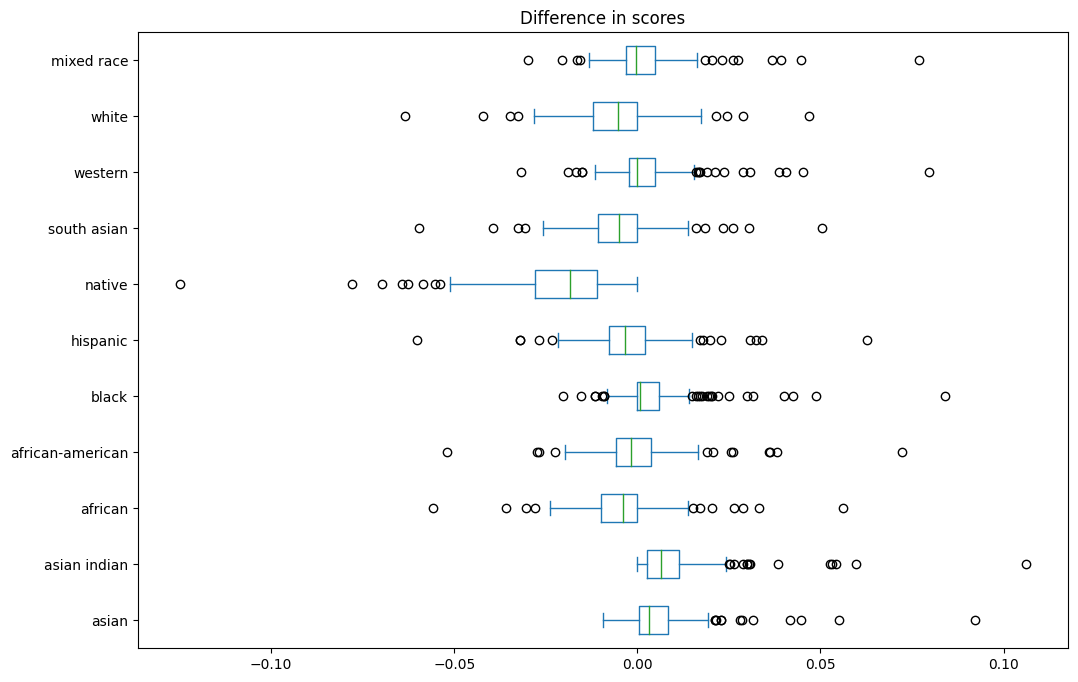

In [72]:
ethnicity_score_df.plot.box(vert=False, figsize=(12, 8));
plt.title("Difference in scores");
plt.savefig("court_ethnicity_array")

In [73]:
nationality_score_df = calculate_all_scores(texts=detected_texts, concept="nationality", clf=clf, n_samples=10000)

0it [00:00, ?it/s]/home/stinal/.cache/pypoetry/virtualenvs/biaslyze-d38187hs-py3.10/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
1499it [00:43, 34.83it/s]


Extracted 477 sample texts for concept nationality


100%|██████████████████████████████████████████████████████████████████████████| 471/471 [00:53<00:00,  8.84it/s]


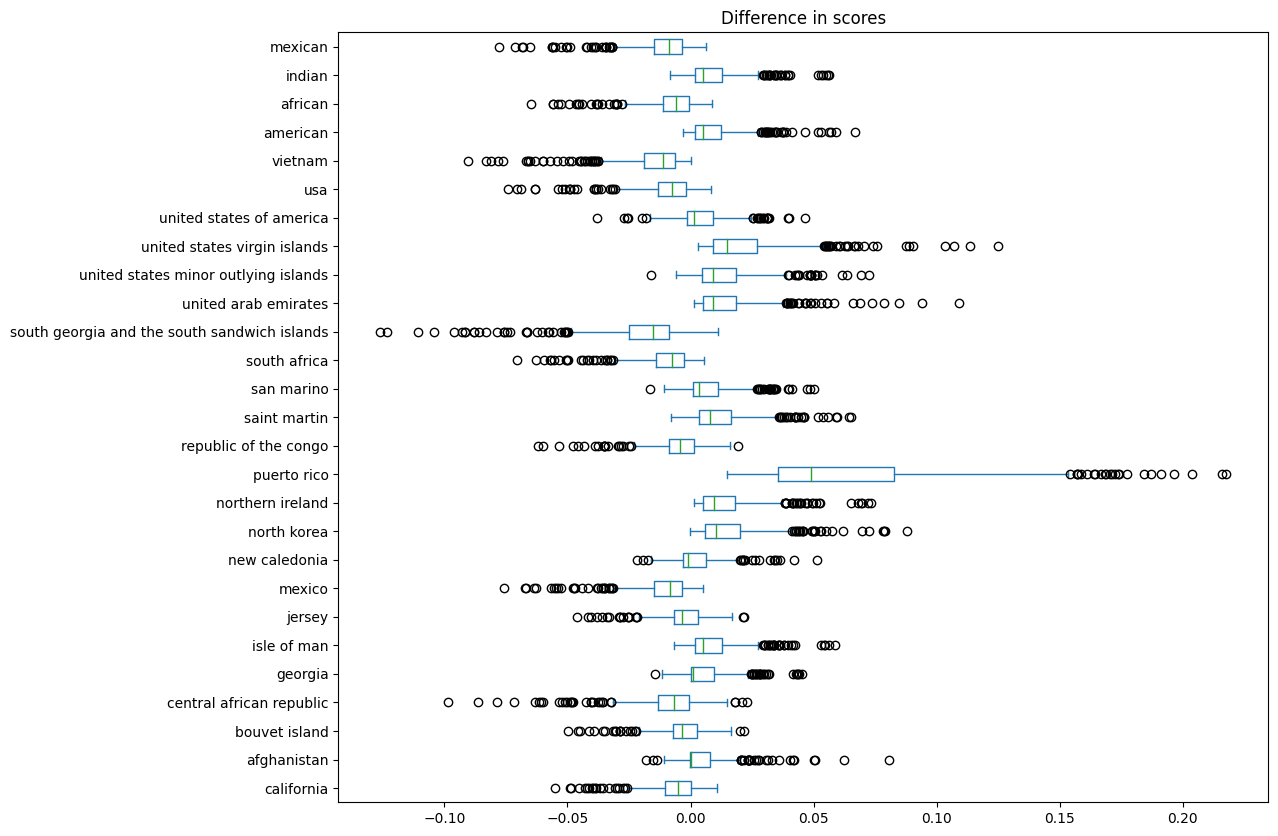

In [75]:
nationality_score_df.plot.box(vert=False, figsize=(12, 10));
plt.title("Difference in scores");
plt.savefig("court_nationality_array")